<a href="https://colab.research.google.com/github/ekaterinatao/NER_biomed_domain/blob/main/active_learning/%D0%92%D0%9A%D0%A0_nerel_bio_RuBioBERT_active_learning_v5_3_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Инструменты
Предобработанный дасасет [NEREL-BIO](https://huggingface.co/datasets/ekaterinatao/nerel_bio_ner_unnested)  

Исходная модель [RuBioBERT](https://huggingface.co/alexyalunin/RuBioBERT)

### Установка зависимостей

In [ ]:
!pip install datasets accelerate evaluate wandb seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import random
from dataclasses import dataclass
import torch
from torch.nn.functional import softmax
import datasets
from datasets import Dataset, DatasetDict, concatenate_datasets
from transformers import (AutoTokenizer,
                          DataCollatorForTokenClassification,
                          AutoModelForTokenClassification,
                          TrainingArguments, Trainer)
import evaluate

import warnings
warnings.filterwarnings("ignore")

In [ ]:
@dataclass
class TrainingConfig:
    seed = 64
    dataset = 'ekaterinatao/nerel_bio_ner_unnested'
    checkpoint = 'alexyalunin/RuBioBERT'
    hf_repo_id = "ekaterinatao/nerel-bio-RuBioBERT-al"
    n_labels = 45
    n_epochs = 10
    train_batch_size = 4
    eval_batch_size = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    l_rate = 5e-05
    w_decay = 0.1
    warm_up = 0.1
    run_name = "RuBioBERT_AL_v5_3"

config = TrainingConfig()

In [ ]:
seed = config.seed

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Скачивание датасета

In [ ]:
dataset = datasets.load_dataset(config.dataset)
dataset

Generating train split:   0%|          | 0/612 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/77 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/77 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 612
    })
    valid: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 77
    })
    test: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 77
    })
})

In [ ]:
# Labels
url = 'https://raw.githubusercontent.com/ekaterinatao/NER_biomed_domain/main/labels.txt'
tags = pd.read_csv(url, names=['tag']).values.tolist()
tags = [item for sublist in tags for item in sublist]
tag_to_id = {tag: i for i, tag in enumerate(tags)}
id_to_tag = {i: tag for i, tag in enumerate(tags)}

___
### Токенизация

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.checkpoint)

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["words"], truncation=True, max_length=512, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_idxs = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_idxs:
            if word_idx is None:
                label_ids.append(-100) # Set the special tokens to -100.
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels, batched=True
)
tokenized_dataset

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 612
    })
    valid: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 77
    })
    test: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 77
    })
})

# Обучение модели

In [ ]:
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [tags[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tags[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
def choose_samples_random(test_predictions, n_tokens) -> np.ndarray:
    """Функция для рандомного отбора примеров для разметки"""

    return random.sample(range(test_predictions.shape[0]), n_tokens)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
print(f'device is {config.device}')

device is cuda


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
os.environ["WANDB_PROJECT"]="ner_bert_nerel_bio"

In [ ]:
def train_and_predict(
    al_train_dataset, eval_dataset, al_test_dataset, test_dataset,
    model, tokenizer, data_collator, compute_metrics
):
    "Функция для тренировки модели, сохранения метрик и предсказаний"

    global config
    training_args = TrainingArguments(
        output_dir=config.hf_repo_id,
        num_train_epochs=config.n_epochs,
        learning_rate=config.l_rate,
        weight_decay=config.w_decay,
        warmup_ratio=config.warm_up,
        per_device_train_batch_size=config.train_batch_size,
        per_device_eval_batch_size=config.eval_batch_size,
        group_by_length=True,
        optim="adamw_torch",
        lr_scheduler_type="cosine",
        evaluation_strategy="epoch",
        seed = config.seed,
        data_seed = config.seed,
        push_to_hub=True,
        save_strategy="no",
        report_to="wandb",
        logging_steps=16,
        run_name=config.run_name,
    )
    metrics = {}
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=al_train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    train_result = trainer.train()
    metrics['train_loss'] = train_result.metrics['train_loss']
    metrics.update(trainer.evaluate(eval_dataset))
    if al_test_dataset.num_rows > 0:
        al_test_predictions = trainer.predict(
            al_test_dataset, metric_key_prefix="pred"
        )
        probas = al_test_predictions.predictions
        metrics.update(al_test_predictions.metrics)
    else:
        probas = None
    test_predictions = trainer.predict(test_dataset, metric_key_prefix="test")
    metrics.update(test_predictions.metrics)

    return metrics, probas, trainer

In [ ]:
def run_active_learning(
    dataset, al_iters, init_train_size, choose_tokens,
    tokenizer, data_collator, compute_metrics
):
    "Функция для реализации цикла активного обучения"

    train_dataset = dataset['train'].select(
        random.sample(
            range(dataset['train'].num_rows),
            int(dataset['train'].num_rows * init_train_size)
        )
    )
    test_dataset = dataset['train'].filter(
        lambda s: s['id'] not in train_dataset['id']
    )
    all_metrics = {}

    for iter in range(al_iters):
        train_size = train_dataset.num_rows
        print(f'\nIteration: {iter}. Training using {train_size} samples')
        model = AutoModelForTokenClassification.from_pretrained(
            config.checkpoint, num_labels=config.n_labels,
            id2label=id_to_tag, label2id=tag_to_id
        )

        metrics, test_predictions, trainer = train_and_predict(
            train_dataset, dataset['valid'], test_dataset, dataset['test'],
            model, tokenizer, data_collator, compute_metrics
        )

        all_metrics[f'{iter}'] = {'train_size': train_size, 'metrics': metrics}

        if test_dataset.num_rows >= choose_tokens:
            assert test_predictions is not None, "test_predictions is None, must be array"
            new_args = choose_samples_random(test_predictions, choose_tokens)
            new_train_samples = test_dataset.select(new_args)
            extended_train_dataset = concatenate_datasets(
                [train_dataset, new_train_samples]
            )

            train_dataset = extended_train_dataset
            test_dataset = dataset['train'].filter(
                lambda s: s['id'] not in train_dataset['id']
            )

    return all_metrics, trainer

____
# Сэмплирование по 2% данных (51 итерация активного обучения)
Обучение на всем датасете.

In [ ]:
metrics, trainer = run_active_learning(
    dataset=tokenized_dataset, al_iters=51, init_train_size=0.02, choose_tokens=12,
    tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics
)

Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 0. Training using 12 samples


config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: Currently logged in as: taoea. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.632662,0.043585,0.045966,0.044744,0.114064
2,No log,3.135697,0.147225,0.030488,0.050515,0.184460
3,No log,2.928094,0.225571,0.057927,0.092181,0.222067
4,No log,2.741565,0.242155,0.121248,0.161588,0.308936
5,No log,2.600920,0.274551,0.154081,0.197386,0.343590
6,2.849300,2.493270,0.281652,0.169559,0.211682,0.363015
7,2.849300,2.403231,0.298573,0.191370,0.233243,0.395183
8,2.849300,2.345297,0.309217,0.208490,0.249054,0.415385
9,2.849300,2.319584,0.317385,0.220919,0.260509,0.427817
10,2.849300,2.314802,0.318884,0.222561,0.262155,0.429681


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 1. Training using 24 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.258212,0.088989,0.013837,0.023950,0.171096
2,No log,2.706058,0.294197,0.102251,0.151758,0.290598
3,2.994800,2.298750,0.355080,0.256567,0.297890,0.457964
4,2.994800,1.959419,0.451043,0.395403,0.421395,0.574825
5,2.994800,1.746147,0.515259,0.475141,0.494388,0.629060
6,1.522900,1.634567,0.539021,0.503752,0.520790,0.646620
7,1.522900,1.542855,0.565754,0.537758,0.551401,0.669619
8,0.900700,1.511526,0.572308,0.544794,0.558212,0.673038
9,0.900700,1.507067,0.573787,0.546201,0.559654,0.672572
10,0.900700,1.506585,0.574243,0.546904,0.560240,0.672727


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 2. Training using 36 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.048866,0.000000,0.000000,0.000000,0.155711
2,3.211600,2.575790,0.273862,0.174953,0.213509,0.364569
3,3.211600,2.045578,0.408483,0.336538,0.369037,0.529138
4,1.861100,1.688056,0.528376,0.506567,0.517241,0.648485
5,1.861100,1.495672,0.582843,0.557692,0.569990,0.682984
6,1.018100,1.409176,0.597826,0.580441,0.589005,0.694949
7,1.018100,1.358601,0.612794,0.593105,0.602789,0.706915
8,0.698700,1.332155,0.619776,0.598265,0.608831,0.710645
9,0.547600,1.323662,0.621969,0.601548,0.611588,0.711733
10,0.547600,1.321658,0.621517,0.601548,0.611369,0.712354


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 3. Training using 48 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.930792,0.239048,0.058865,0.094467,0.229837
2,3.242600,2.151789,0.437052,0.357411,0.393240,0.542968
3,1.900600,1.579228,0.584829,0.542448,0.562842,0.681274
4,1.064100,1.379651,0.607117,0.584193,0.595434,0.697436
5,1.064100,1.263068,0.635024,0.616557,0.625654,0.721057
6,0.692700,1.199827,0.647059,0.632036,0.639459,0.727273
7,0.466500,1.170249,0.654602,0.640478,0.647463,0.732712
8,0.410200,1.140462,0.666105,0.648921,0.657401,0.740637
9,0.410200,1.138182,0.667874,0.648452,0.658020,0.741259
10,0.373600,1.135990,0.669729,0.649625,0.659524,0.742347


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 4. Training using 60 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.875495,0.071111,0.003752,0.007129,0.161461
2,3.358600,2.022067,0.412755,0.350610,0.379153,0.536131
3,2.162800,1.521856,0.572034,0.538227,0.554616,0.674592
4,1.255900,1.307490,0.615025,0.585600,0.599952,0.703963
5,0.824500,1.167183,0.646273,0.624296,0.635095,0.727273
6,0.614800,1.101239,0.663385,0.647983,0.655594,0.742347
7,0.430000,1.045103,0.671998,0.660178,0.666036,0.756488
8,0.343200,1.036980,0.684892,0.669794,0.677259,0.763015
9,0.318700,1.028504,0.684059,0.667214,0.675531,0.763636
10,0.294300,1.027071,0.685323,0.669090,0.677109,0.764258


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 5. Training using 72 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.310500,2.780037,0.248405,0.136961,0.176568,0.319037
2,2.218800,1.755293,0.472756,0.421201,0.445492,0.594561
3,1.267400,1.347509,0.605276,0.575750,0.590144,0.696503
4,0.780300,1.166820,0.640760,0.624531,0.632542,0.727584
5,0.565100,1.056982,0.678589,0.658537,0.668412,0.758664
6,0.437300,1.003115,0.691934,0.667917,0.679714,0.772339
7,0.341100,0.976898,0.701835,0.681754,0.691649,0.781041
8,0.231900,0.957916,0.712262,0.683865,0.697775,0.786014
9,0.213300,0.944468,0.715992,0.688790,0.702128,0.789588
10,0.202700,0.943583,0.714842,0.689024,0.701696,0.789277


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 6. Training using 84 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.445900,2.723423,0.206096,0.139540,0.166410,0.331313
2,2.311900,1.627296,0.553181,0.509850,0.530632,0.652214
3,1.432900,1.317834,0.615496,0.599906,0.607601,0.707848
4,0.638900,1.138077,0.649891,0.629925,0.639752,0.734421
5,0.529500,1.032708,0.682459,0.658771,0.670406,0.758974
6,0.405800,0.976116,0.706343,0.676360,0.691027,0.771873
7,0.274400,0.940401,0.715962,0.686914,0.701137,0.781197
8,0.232300,0.945170,0.718941,0.688086,0.703176,0.782595
9,0.189200,0.940844,0.719470,0.688086,0.703428,0.784460
10,0.185000,0.939459,0.719961,0.688555,0.703908,0.785082


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 7. Training using 96 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.451600,2.648171,0.307626,0.168386,0.217642,0.366434
2,1.533400,1.499476,0.606138,0.555816,0.579887,0.690754
3,0.919300,1.203696,0.635404,0.606942,0.620847,0.713908
4,0.553300,1.065839,0.680000,0.653846,0.666667,0.752603
5,0.441300,0.949631,0.716570,0.693715,0.704957,0.787723
6,0.318200,0.887432,0.731796,0.707083,0.719227,0.799534
7,0.243000,0.843002,0.739990,0.719512,0.729608,0.809790
8,0.208800,0.847152,0.733701,0.717871,0.725699,0.808392
9,0.155500,0.851225,0.738164,0.723968,0.730997,0.811033
10,0.155400,0.851344,0.737395,0.723734,0.730501,0.810878


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 8. Training using 108 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.496900,2.514510,0.341643,0.250704,0.289192,0.452991
2,1.549100,1.431360,0.592365,0.564024,0.577847,0.693551
3,0.768100,1.177878,0.639822,0.607411,0.623195,0.719658
4,0.614600,1.000301,0.706043,0.668621,0.686822,0.762082
5,0.396400,0.909800,0.725580,0.703799,0.714524,0.795649
6,0.277800,0.865298,0.746670,0.723030,0.734660,0.808081
7,0.225000,0.856474,0.740918,0.727017,0.733902,0.811655
8,0.161400,0.847264,0.749104,0.735225,0.742100,0.818026
9,0.127300,0.845816,0.745896,0.735225,0.740522,0.817405
10,0.145200,0.846695,0.745299,0.734287,0.739752,0.817094


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 9. Training using 120 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.529900,2.416924,0.347585,0.249765,0.290666,0.436208
2,1.602800,1.311463,0.631373,0.604128,0.617450,0.714375
3,0.823700,1.034615,0.694369,0.662289,0.677950,0.767677
4,0.516200,0.924028,0.720354,0.688086,0.703850,0.788967
5,0.384400,0.811541,0.748054,0.721388,0.734479,0.814297
6,0.256400,0.807553,0.743399,0.726313,0.734757,0.813054
7,0.190200,0.798874,0.753651,0.738274,0.745883,0.821134
8,0.163000,0.785146,0.752622,0.740619,0.746572,0.822844
9,0.147700,0.789394,0.753620,0.744606,0.749086,0.824087
10,0.133000,0.789854,0.753978,0.744606,0.749263,0.823932


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 10. Training using 132 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.728700,2.412494,0.341096,0.233583,0.277283,0.429681
2,1.264400,1.321503,0.609902,0.598030,0.603908,0.707692
3,0.768900,1.067410,0.655606,0.648687,0.652128,0.746387
4,0.451800,0.883959,0.719666,0.708021,0.713796,0.793318
5,0.310000,0.818543,0.749282,0.733818,0.741469,0.814141
6,0.232000,0.801342,0.749461,0.733818,0.741557,0.817249
7,0.169000,0.789577,0.759255,0.745544,0.752337,0.822688
8,0.149600,0.798409,0.755476,0.744137,0.749764,0.824864
9,0.112800,0.796167,0.759365,0.751173,0.755246,0.827817
10,0.101200,0.796778,0.758424,0.749531,0.753951,0.827040


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 11. Training using 144 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.735700,2.146307,0.423984,0.349906,0.383400,0.546232
2,1.163300,1.204484,0.642771,0.626642,0.634604,0.726807
3,0.690600,0.949811,0.725870,0.694887,0.710041,0.790987
4,0.442100,0.827503,0.751452,0.728189,0.739638,0.816939
5,0.265600,0.771976,0.756976,0.744371,0.750621,0.824709
6,0.222800,0.738626,0.770312,0.758208,0.764212,0.833722
7,0.162200,0.748482,0.765488,0.756332,0.760882,0.829837
8,0.119800,0.733310,0.770740,0.764775,0.767746,0.833877
9,0.108200,0.733790,0.772533,0.763837,0.768160,0.833722
10,0.091800,0.733384,0.771963,0.764540,0.768234,0.834033


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 12. Training using 156 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.809000,2.069587,0.403800,0.318949,0.356394,0.526651
2,1.234300,1.164547,0.655819,0.623827,0.639423,0.734577
3,0.674700,0.871860,0.745297,0.706144,0.725193,0.796737
4,0.391500,0.799153,0.751512,0.728424,0.739788,0.811500
5,0.274700,0.755629,0.759953,0.752111,0.756011,0.825019
6,0.188600,0.719305,0.766190,0.754690,0.760397,0.829215
7,0.141900,0.741851,0.774010,0.765478,0.769721,0.835431
8,0.109900,0.732283,0.769777,0.762195,0.765967,0.834188
9,0.090500,0.721650,0.778675,0.768996,0.773805,0.838228
10,0.087400,0.722459,0.778675,0.768996,0.773805,0.838695


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 13. Training using 168 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.762200,1.973672,0.437043,0.378518,0.405681,0.561772
2,0.973100,1.173181,0.641848,0.628752,0.635233,0.728361
3,0.652600,0.897942,0.730299,0.699812,0.714731,0.796115
4,0.386600,0.760844,0.763177,0.736867,0.749791,0.824398
5,0.266600,0.710456,0.773923,0.758677,0.766225,0.834965
6,0.186800,0.732352,0.764790,0.754925,0.759825,0.832789
7,0.152400,0.718041,0.774285,0.768293,0.771277,0.836674
8,0.097000,0.712299,0.780105,0.768762,0.774392,0.842424
9,0.101300,0.711449,0.781495,0.772514,0.776978,0.843357
10,0.077600,0.712913,0.781465,0.773218,0.777319,0.843512


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 14. Training using 180 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.803600,1.819374,0.490672,0.431754,0.459331,0.593473
2,1.031300,1.079132,0.678208,0.656895,0.667381,0.754468
3,0.598800,0.823976,0.747627,0.720450,0.733787,0.809635
4,0.322400,0.727032,0.766366,0.757739,0.762028,0.833256
5,0.235700,0.697886,0.778303,0.772280,0.775280,0.841492
6,0.177800,0.711100,0.766003,0.757739,0.761849,0.834499
7,0.127600,0.708587,0.771178,0.764306,0.767727,0.838384
8,0.107400,0.714458,0.777830,0.771811,0.774809,0.843201
9,0.084000,0.719246,0.775260,0.770169,0.772706,0.842735
10,0.077100,0.720633,0.776285,0.772280,0.774277,0.843357


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 15. Training using 192 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.199200,1.848834,0.485635,0.408302,0.443623,0.585859
2,0.985800,1.121271,0.672947,0.653377,0.663018,0.748096
3,0.577400,0.821108,0.757523,0.720216,0.738399,0.817560
4,0.295300,0.723010,0.767609,0.751407,0.759422,0.831080
5,0.247100,0.698431,0.768516,0.756801,0.762614,0.833877
6,0.162200,0.708813,0.772846,0.763602,0.768196,0.836985
7,0.115500,0.707937,0.771523,0.765009,0.768252,0.839005
8,0.096900,0.711599,0.770759,0.764071,0.767401,0.838539
9,0.072100,0.720219,0.767617,0.763837,0.765722,0.837451
10,0.064500,0.720652,0.767327,0.763368,0.765342,0.836985


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 16. Training using 204 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.234300,1.796564,0.455531,0.384381,0.416942,0.571251
2,0.942600,0.991714,0.707263,0.678236,0.692446,0.774670
3,0.586100,0.789369,0.739729,0.717871,0.728636,0.806682
4,0.354800,0.678177,0.766137,0.746013,0.755941,0.832634
5,0.231600,0.710339,0.763065,0.756801,0.759920,0.830458
6,0.128300,0.706958,0.771959,0.760553,0.766214,0.834810
7,0.125300,0.708774,0.771624,0.767824,0.769719,0.839005
8,0.080800,0.702422,0.771665,0.766417,0.769032,0.839938
9,0.068600,0.699517,0.772781,0.765713,0.769231,0.840093
10,0.065300,0.698906,0.772415,0.765713,0.769050,0.840093


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 17. Training using 216 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.251100,1.756172,0.484575,0.416276,0.447837,0.593318
2,0.937800,1.068019,0.694213,0.663931,0.678734,0.769386
3,0.518500,0.782971,0.757150,0.732645,0.744696,0.818803
4,0.321900,0.695256,0.762494,0.751407,0.756910,0.829526
5,0.206400,0.689404,0.769912,0.754925,0.762345,0.832789
6,0.162700,0.677672,0.777540,0.766417,0.771938,0.839472
7,0.124700,0.696046,0.770755,0.766417,0.768579,0.838228
8,0.086500,0.695179,0.775960,0.767589,0.771752,0.841803
9,0.074500,0.698170,0.775674,0.768762,0.772203,0.841336
10,0.074900,0.695833,0.774125,0.767589,0.770843,0.840870


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 18. Training using 228 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.155800,1.593237,0.557757,0.508443,0.531959,0.651748
2,0.780600,0.914513,0.727806,0.697936,0.712558,0.793939
3,0.462000,0.704025,0.764255,0.748124,0.756103,0.832479
4,0.309000,0.661615,0.771571,0.761257,0.766379,0.834499
5,0.240300,0.673731,0.779657,0.767589,0.773576,0.839938
6,0.155200,0.641193,0.770996,0.764306,0.767636,0.838384
7,0.113100,0.648862,0.776473,0.775563,0.776018,0.844911
8,0.086000,0.666732,0.777148,0.772045,0.774588,0.843357
9,0.064200,0.675456,0.775165,0.772983,0.774072,0.841647
10,0.057300,0.675521,0.774064,0.771341,0.772701,0.841181


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 19. Training using 240 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.318300,1.632656,0.537760,0.484287,0.509625,0.640559
2,0.780100,0.919690,0.724641,0.686914,0.705273,0.785548
3,0.452000,0.705804,0.761415,0.746951,0.754114,0.829992
4,0.318300,0.660868,0.762018,0.754690,0.758336,0.832945
5,0.229800,0.695912,0.762696,0.753752,0.758198,0.832789
6,0.152500,0.661631,0.778095,0.768058,0.773044,0.845377
7,0.112000,0.667459,0.780616,0.766886,0.773690,0.847708
8,0.078000,0.708696,0.772170,0.767824,0.769991,0.843046
9,0.066100,0.704246,0.773585,0.769231,0.771402,0.844444
10,0.063800,0.701963,0.776179,0.771811,0.773989,0.845688


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 20. Training using 252 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.272900,1.495218,0.578656,0.539165,0.558213,0.665579
2,0.836300,0.860387,0.732308,0.703799,0.717771,0.797203
3,0.473400,0.687804,0.771574,0.748593,0.759910,0.831080
4,0.291400,0.651182,0.781077,0.758912,0.769835,0.840715
5,0.179500,0.664792,0.780235,0.777674,0.778952,0.843978
6,0.130400,0.659769,0.781449,0.776501,0.778967,0.846620
7,0.096300,0.682230,0.781942,0.777908,0.779920,0.846931
8,0.080500,0.685728,0.784051,0.781660,0.782854,0.850039
9,0.062400,0.692162,0.782465,0.778612,0.780534,0.848951
10,0.062000,0.689226,0.784013,0.779784,0.781893,0.850039


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 21. Training using 264 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.573300,1.504235,0.583376,0.530019,0.555419,0.671484
2,0.718100,0.831185,0.738645,0.713180,0.725689,0.807304
3,0.455900,0.676892,0.771533,0.743668,0.757344,0.831546
4,0.301200,0.614488,0.780604,0.770169,0.775351,0.843357
5,0.168700,0.617505,0.779637,0.775797,0.777712,0.849106
6,0.118000,0.648881,0.783899,0.774156,0.778997,0.847708
7,0.086500,0.615720,0.790376,0.789634,0.790005,0.856721
8,0.076300,0.642584,0.783037,0.783771,0.783404,0.852370
9,0.050200,0.647877,0.781353,0.780253,0.780803,0.851437
10,0.060100,0.649502,0.780883,0.779784,0.780333,0.851437


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 22. Training using 276 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.670100,1.410714,0.597074,0.564728,0.580451,0.679254
2,0.735400,0.781398,0.751644,0.723968,0.737546,0.812898
3,0.490300,0.637253,0.779900,0.766182,0.772980,0.841336
4,0.302000,0.603183,0.783361,0.775094,0.779205,0.845377
5,0.199500,0.622350,0.784648,0.776735,0.780672,0.845998
6,0.124800,0.634760,0.783524,0.785178,0.784350,0.852214
7,0.094300,0.627504,0.790274,0.792683,0.791476,0.856099
8,0.073900,0.651764,0.792149,0.785647,0.788885,0.853924
9,0.062900,0.661116,0.791441,0.789400,0.790419,0.855167
10,0.050900,0.660857,0.792205,0.791276,0.791740,0.855789


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 23. Training using 288 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.709400,1.459005,0.593297,0.556285,0.574195,0.685004
2,0.604500,0.802117,0.741935,0.706614,0.723844,0.806993
3,0.455100,0.642525,0.783159,0.754690,0.768661,0.841958
4,0.246000,0.609688,0.775198,0.759381,0.767208,0.839782
5,0.203900,0.634908,0.783975,0.777908,0.780930,0.847397
6,0.121400,0.608607,0.786632,0.789400,0.788014,0.853458
7,0.081900,0.615624,0.786570,0.785647,0.786108,0.855012
8,0.066400,0.645491,0.789215,0.789400,0.789307,0.856721
9,0.048600,0.646686,0.791706,0.792448,0.792077,0.858586
10,0.051100,0.648857,0.792126,0.792683,0.792404,0.858741


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 24. Training using 300 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.689100,1.399498,0.587227,0.554174,0.570222,0.671950
2,0.645600,0.800257,0.754740,0.728189,0.741227,0.813675
3,0.376900,0.647734,0.782619,0.766651,0.774553,0.843046
4,0.282800,0.634292,0.783571,0.771811,0.777647,0.840093
5,0.202200,0.614404,0.789127,0.786351,0.787736,0.852059
6,0.116800,0.621342,0.784961,0.785882,0.785421,0.852370
7,0.107200,0.641735,0.791951,0.789165,0.790556,0.854390
8,0.078000,0.649710,0.793483,0.793856,0.793669,0.855944
9,0.058700,0.652036,0.798169,0.797608,0.797889,0.858120
10,0.050200,0.653889,0.797510,0.796201,0.796855,0.857187


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 25. Training using 312 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.688600,1.342338,0.617501,0.584193,0.600386,0.701787
2,0.710100,0.749475,0.758961,0.739916,0.749317,0.822999
3,0.396300,0.659139,0.766413,0.755629,0.760983,0.829992
4,0.287900,0.603462,0.789712,0.777674,0.783646,0.849573
5,0.188800,0.620792,0.784936,0.777205,0.781051,0.847086
6,0.137900,0.656660,0.778723,0.772514,0.775606,0.842269
7,0.079100,0.621616,0.788779,0.784709,0.786739,0.853924
8,0.059200,0.653200,0.785697,0.780722,0.783202,0.849883
9,0.044400,0.663532,0.782629,0.777674,0.780144,0.847708
10,0.055800,0.666433,0.783306,0.779081,0.781188,0.848485


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 26. Training using 324 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.374800,1.374827,0.609104,0.577392,0.592824,0.690132
2,0.636600,0.772286,0.751972,0.715291,0.733173,0.814918
3,0.387000,0.668702,0.772716,0.751876,0.762154,0.834033
4,0.258600,0.605559,0.790211,0.780019,0.785082,0.848019
5,0.171400,0.596565,0.792417,0.784240,0.788307,0.855944
6,0.114100,0.638929,0.779986,0.773218,0.776587,0.845377
7,0.100900,0.648282,0.789300,0.785413,0.787352,0.852991
8,0.067400,0.658559,0.787736,0.783302,0.785513,0.854079
9,0.049600,0.665579,0.785108,0.781426,0.783263,0.852214
10,0.041600,0.667739,0.786673,0.783537,0.785102,0.853458


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 27. Training using 336 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.258700,1.331569,0.597335,0.567777,0.582181,0.686558
2,0.671800,0.778382,0.755707,0.729831,0.742544,0.814763
3,0.355600,0.626588,0.790977,0.772983,0.781876,0.846465
4,0.227200,0.640026,0.784503,0.781191,0.782844,0.845377
5,0.176200,0.640376,0.782352,0.775563,0.778942,0.846309
6,0.114800,0.649100,0.793527,0.787758,0.790632,0.850505
7,0.085400,0.655886,0.795701,0.790103,0.792892,0.855633
8,0.055400,0.686131,0.792462,0.788931,0.790692,0.852681
9,0.058500,0.684952,0.794575,0.790103,0.792333,0.853924
10,0.040800,0.687484,0.792884,0.789165,0.791020,0.853302


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 28. Training using 348 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.249400,1.236098,0.650086,0.622186,0.635830,0.726030
2,0.652400,0.717582,0.769324,0.744606,0.756763,0.828438
3,0.387200,0.625540,0.790176,0.777205,0.783637,0.841958
4,0.261200,0.633503,0.781879,0.765009,0.773352,0.837141
5,0.150500,0.633490,0.780431,0.781895,0.781162,0.845221
6,0.136900,0.606393,0.785157,0.779081,0.782107,0.850039
7,0.067800,0.643735,0.785865,0.787523,0.786693,0.849262
8,0.072600,0.648267,0.784846,0.787054,0.785948,0.852525
9,0.051800,0.654980,0.788967,0.788227,0.788597,0.853924
10,0.047900,0.657835,0.786954,0.786585,0.786770,0.852525


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 29. Training using 360 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.302400,1.202205,0.644616,0.607880,0.625709,0.723854
2,0.613900,0.783486,0.751628,0.731004,0.741172,0.808081
3,0.356900,0.664720,0.770799,0.762664,0.766710,0.836053
4,0.256400,0.578823,0.786928,0.782129,0.784521,0.853768
5,0.135900,0.602519,0.776531,0.779081,0.777804,0.849883
6,0.128500,0.596128,0.795086,0.781660,0.788316,0.858430
7,0.092600,0.609260,0.795119,0.794559,0.794839,0.862471
8,0.055200,0.636805,0.794401,0.791979,0.793188,0.861538
9,0.056700,0.636119,0.798822,0.795263,0.797038,0.864491
10,0.046700,0.637704,0.797787,0.794794,0.796288,0.863869


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 30. Training using 372 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.374300,1.231934,0.637357,0.601782,0.619059,0.717016
2,0.670600,0.707129,0.769623,0.742730,0.755937,0.826884
3,0.394500,0.630103,0.767878,0.757974,0.762894,0.839472
4,0.232600,0.603465,0.794810,0.775797,0.785189,0.848640
5,0.148200,0.606729,0.790068,0.787289,0.788676,0.851748
6,0.115800,0.612653,0.792795,0.789634,0.791211,0.857964
7,0.077400,0.620057,0.793606,0.791745,0.792674,0.859518
8,0.065700,0.645988,0.792519,0.790103,0.791309,0.858120
9,0.044300,0.652820,0.794401,0.791979,0.793188,0.858897
10,0.039900,0.655437,0.794824,0.792214,0.793517,0.858275


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 31. Training using 384 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.055300,1.211753,0.640753,0.622420,0.631454,0.724320
2,0.542400,0.722867,0.760864,0.743199,0.751928,0.824242
3,0.417900,0.618792,0.780278,0.764540,0.772329,0.841492
4,0.235800,0.590041,0.784903,0.777908,0.781390,0.848019
5,0.163500,0.630019,0.778667,0.775563,0.777112,0.846154
6,0.110200,0.604317,0.790364,0.788696,0.789529,0.857032
7,0.071900,0.665621,0.786567,0.788227,0.787396,0.853768
8,0.070100,0.671171,0.783076,0.785647,0.784360,0.853924
9,0.045300,0.678691,0.784781,0.788462,0.786617,0.855789
10,0.042200,0.677890,0.787652,0.789869,0.788759,0.857187


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 32. Training using 396 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.063100,1.203414,0.650950,0.618433,0.634275,0.724786
2,0.589200,0.691171,0.762956,0.745779,0.754269,0.827972
3,0.395000,0.592907,0.790592,0.776501,0.783483,0.846775
4,0.245900,0.560230,0.791206,0.789165,0.790184,0.857032
5,0.174300,0.592248,0.797180,0.795497,0.796338,0.860295
6,0.092200,0.604508,0.799764,0.795263,0.797507,0.863248
7,0.064900,0.608358,0.800712,0.791510,0.796084,0.863559
8,0.055000,0.620035,0.804037,0.803471,0.803754,0.866822
9,0.055200,0.622933,0.804746,0.803236,0.803991,0.868687
10,0.037800,0.624691,0.804271,0.803705,0.803988,0.868842


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 33. Training using 408 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.115200,1.214281,0.645486,0.617026,0.630935,0.720901
2,0.637800,0.698193,0.764720,0.743199,0.753806,0.829215
3,0.368300,0.588557,0.787026,0.773921,0.780419,0.848019
4,0.221200,0.578769,0.782456,0.784475,0.783464,0.850505
5,0.180300,0.586512,0.794111,0.784240,0.789145,0.856566
6,0.097400,0.580999,0.796318,0.801360,0.798831,0.862160
7,0.078100,0.611215,0.796658,0.793856,0.795254,0.860917
8,0.050800,0.631035,0.796614,0.794559,0.795585,0.859984
9,0.041400,0.642865,0.797190,0.798311,0.797750,0.861383
10,0.038800,0.644431,0.797421,0.797608,0.797514,0.861228


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 34. Training using 420 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.192900,1.132309,0.654119,0.627580,0.640575,0.733644
2,0.565100,0.671604,0.770369,0.745075,0.757511,0.832634
3,0.362300,0.609955,0.785765,0.771576,0.778606,0.845843
4,0.226300,0.560997,0.787964,0.786116,0.787039,0.851127
5,0.168200,0.612110,0.775116,0.781660,0.778375,0.848174
6,0.093000,0.596061,0.794408,0.792917,0.793662,0.859207
7,0.089800,0.612082,0.797240,0.799484,0.798361,0.861383
8,0.052300,0.635927,0.804861,0.807692,0.806274,0.865734
9,0.030500,0.635153,0.801498,0.803002,0.802249,0.863714
10,0.036500,0.636695,0.802108,0.803236,0.802672,0.863869


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 35. Training using 432 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.115200,1.134559,0.654070,0.633208,0.643470,0.735975
2,0.621100,0.668175,0.773157,0.767355,0.770245,0.839938
3,0.313000,0.617691,0.766564,0.757036,0.761770,0.834499
4,0.196600,0.596812,0.783993,0.785647,0.784819,0.850039
5,0.177700,0.563251,0.802780,0.799015,0.800893,0.863714
6,0.117900,0.610859,0.793476,0.792917,0.793196,0.858741
7,0.068800,0.600744,0.801460,0.798077,0.799765,0.862471
8,0.042100,0.615794,0.799344,0.800657,0.800000,0.862315
9,0.056600,0.623492,0.797616,0.800422,0.799017,0.862315
10,0.036700,0.625279,0.798551,0.801360,0.799953,0.862937


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 36. Training using 444 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.097400,1.137107,0.647381,0.637664,0.642486,0.733333
2,0.589500,0.679791,0.762251,0.736867,0.749344,0.824864
3,0.364400,0.609655,0.780471,0.777908,0.779187,0.846620
4,0.238600,0.568410,0.796528,0.806989,0.801724,0.863559
5,0.164400,0.596200,0.791510,0.791510,0.791510,0.856410
6,0.109100,0.603565,0.793007,0.797842,0.795417,0.858120
7,0.073000,0.610081,0.802334,0.806285,0.804305,0.866977
8,0.058600,0.626626,0.803425,0.803236,0.803331,0.865113
9,0.041800,0.638652,0.801496,0.803940,0.802716,0.865734
10,0.039300,0.639310,0.799626,0.803002,0.801311,0.864957


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 37. Training using 456 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.000600,1.179779,0.643476,0.626876,0.635068,0.725253
2,0.556000,0.645339,0.770618,0.751642,0.761012,0.833256
3,0.360400,0.581241,0.786660,0.780019,0.783325,0.852059
4,0.253600,0.589796,0.778348,0.782364,0.780351,0.850971
5,0.222900,0.551565,0.798916,0.794794,0.796849,0.862626
6,0.114900,0.601339,0.801871,0.803940,0.802904,0.867133
7,0.083600,0.595594,0.796697,0.803236,0.799953,0.868376
8,0.036300,0.625882,0.801400,0.805347,0.803369,0.866977
9,0.033200,0.630694,0.802466,0.808865,0.805653,0.868998
10,0.037300,0.631274,0.803210,0.809803,0.806493,0.869153


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 38. Training using 468 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.965300,1.094991,0.658632,0.634381,0.646279,0.737995
2,0.611100,0.634134,0.766762,0.750938,0.758768,0.832945
3,0.350600,0.567735,0.798193,0.787523,0.792823,0.858741
4,0.199300,0.554964,0.795551,0.788462,0.791991,0.860140
5,0.143400,0.571781,0.797044,0.796670,0.796857,0.862160
6,0.115400,0.562491,0.801593,0.802533,0.802063,0.866822
7,0.075000,0.576603,0.802724,0.801595,0.802159,0.868687
8,0.044100,0.595972,0.802681,0.800422,0.801550,0.868842
9,0.035700,0.614695,0.799485,0.800422,0.799953,0.866667
10,0.030700,0.614738,0.800889,0.802767,0.801827,0.867599


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 39. Training using 480 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.066500,1.029148,0.692176,0.666041,0.678857,0.765967
2,0.489900,0.629912,0.778469,0.763133,0.770725,0.841803
3,0.366000,0.569072,0.788984,0.776032,0.782454,0.854701
4,0.210500,0.537578,0.797170,0.792683,0.794920,0.860451
5,0.183700,0.559074,0.794062,0.790338,0.792196,0.860917
6,0.093000,0.591566,0.794207,0.797373,0.795787,0.861383
7,0.060000,0.627673,0.797190,0.798311,0.797750,0.860917
8,0.036200,0.623270,0.802301,0.801360,0.801830,0.864336
9,0.040200,0.639154,0.801690,0.801126,0.801408,0.864491
10,0.035700,0.638579,0.801079,0.800891,0.800985,0.864491


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 40. Training using 492 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.980700,1.033398,0.682127,0.658771,0.670246,0.758819
2,0.505500,0.688092,0.759634,0.739681,0.749525,0.821756
3,0.326200,0.577262,0.793647,0.779315,0.786416,0.853458
4,0.241800,0.555515,0.795276,0.781660,0.788409,0.858897
5,0.137600,0.565884,0.796952,0.797139,0.797045,0.864802
6,0.092300,0.583008,0.797003,0.798311,0.797657,0.863403
7,0.080800,0.597010,0.803375,0.803940,0.803657,0.868376
8,0.049400,0.606976,0.802064,0.802064,0.802064,0.867444
9,0.028100,0.623840,0.798736,0.800422,0.799578,0.865890
10,0.042300,0.627387,0.797430,0.800422,0.798923,0.866200


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 41. Training using 504 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.036500,1.023654,0.695122,0.668386,0.681492,0.771873
2,0.496100,0.657451,0.768264,0.759615,0.763915,0.839316
3,0.311300,0.574114,0.786373,0.779550,0.782947,0.851904
4,0.206400,0.519234,0.799238,0.787054,0.793099,0.863714
5,0.136400,0.553842,0.795279,0.798077,0.796676,0.864957
6,0.084600,0.597807,0.786381,0.790807,0.788587,0.860295
7,0.047300,0.587748,0.791609,0.800891,0.796223,0.864180
8,0.036600,0.622345,0.794931,0.801829,0.798365,0.865268
9,0.040800,0.640088,0.796257,0.798311,0.797283,0.864180
10,0.035800,0.639148,0.795661,0.799953,0.797801,0.864646


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 42. Training using 516 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.873200,1.014965,0.708354,0.672139,0.689771,0.776535
2,0.491900,0.618949,0.783207,0.774390,0.778774,0.843046
3,0.337200,0.533939,0.798720,0.790103,0.794388,0.857343
4,0.211600,0.554322,0.784583,0.790103,0.787333,0.857809
5,0.149800,0.529237,0.794872,0.799719,0.797288,0.863248
6,0.079500,0.586943,0.798968,0.798780,0.798874,0.860761
7,0.056100,0.608108,0.797855,0.802533,0.800187,0.862782
8,0.038400,0.600371,0.803784,0.806989,0.805383,0.867754
9,0.030100,0.618239,0.802057,0.804878,0.803465,0.866667
10,0.038100,0.618365,0.803692,0.806520,0.805104,0.867444


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 43. Training using 528 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.014800,1.017767,0.702490,0.668386,0.685014,0.770785
2,0.511900,0.660205,0.781492,0.756567,0.768827,0.839316
3,0.329500,0.556483,0.795735,0.787523,0.791608,0.859207
4,0.196900,0.538065,0.796427,0.794559,0.795492,0.863248
5,0.144100,0.547099,0.794291,0.789634,0.791956,0.861694
6,0.089000,0.562653,0.804312,0.804878,0.804595,0.868687
7,0.073700,0.619924,0.798975,0.804409,0.801683,0.863869
8,0.037300,0.599959,0.803817,0.810038,0.806915,0.870552
9,0.030700,0.622017,0.799767,0.805582,0.802664,0.867444
10,0.027300,0.622942,0.800606,0.806051,0.803319,0.867910


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 44. Training using 540 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.972400,0.994622,0.704862,0.676595,0.690439,0.773582
2,0.552100,0.609331,0.772137,0.766886,0.769502,0.841336
3,0.282500,0.578076,0.794726,0.784475,0.789567,0.855012
4,0.215500,0.551182,0.808074,0.802767,0.805412,0.867910
5,0.130300,0.554346,0.797555,0.795497,0.796525,0.862626
6,0.105400,0.569654,0.797616,0.800422,0.799017,0.863869
7,0.059800,0.585189,0.799250,0.799250,0.799250,0.865113
8,0.035000,0.605793,0.804627,0.807458,0.806040,0.868376
9,0.039900,0.616726,0.802761,0.804644,0.803701,0.866511
10,0.034400,0.617550,0.803279,0.804409,0.803843,0.866977


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 45. Training using 552 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.935700,1.050588,0.690248,0.659006,0.674265,0.764880
2,0.530000,0.600296,0.775907,0.767355,0.771607,0.845221
3,0.305700,0.550432,0.797822,0.790338,0.794062,0.855789
4,0.203300,0.553548,0.804533,0.799250,0.801882,0.864180
5,0.112400,0.579929,0.805216,0.803705,0.804460,0.865423
6,0.098400,0.608803,0.802003,0.807458,0.804721,0.865423
7,0.052000,0.622510,0.798266,0.799015,0.798640,0.864180
8,0.029300,0.636936,0.798469,0.807458,0.802938,0.867288
9,0.027600,0.653656,0.799674,0.805113,0.802384,0.866045
10,0.025000,0.654324,0.798789,0.804409,0.801589,0.865890


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 46. Training using 564 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.963800,0.997591,0.703908,0.659006,0.680717,0.772339
2,0.481900,0.630534,0.763542,0.760319,0.761927,0.834810
3,0.312200,0.605662,0.772492,0.769231,0.770858,0.843046
4,0.186600,0.549725,0.800376,0.799250,0.799812,0.860761
5,0.128200,0.553777,0.804872,0.805816,0.805344,0.864646
6,0.102800,0.585201,0.805987,0.814493,0.810218,0.869308
7,0.062600,0.587796,0.808799,0.810507,0.809652,0.868531
8,0.047200,0.622012,0.801911,0.806989,0.804442,0.866356
9,0.030000,0.640943,0.805037,0.809568,0.807297,0.867599
10,0.019900,0.642790,0.802797,0.807692,0.805237,0.866356


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 47. Training using 576 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.888300,0.978375,0.715350,0.675422,0.694813,0.768298
2,0.511700,0.663726,0.762951,0.749531,0.756181,0.828749
3,0.327400,0.527421,0.790277,0.789165,0.789721,0.856566
4,0.217400,0.551847,0.788956,0.790807,0.789881,0.857032
5,0.130100,0.565352,0.799672,0.801360,0.800515,0.861538
6,0.111600,0.547003,0.811489,0.811679,0.811584,0.872416
7,0.060200,0.595057,0.797580,0.803940,0.800747,0.864025
8,0.043900,0.615453,0.802840,0.808865,0.805841,0.867444
9,0.034100,0.613154,0.806482,0.811210,0.808839,0.869619
10,0.033000,0.617732,0.805543,0.811210,0.808366,0.869619


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 48. Training using 588 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.965500,0.970925,0.709527,0.679409,0.694142,0.782284
2,0.495800,0.608455,0.781435,0.773921,0.777660,0.841026
3,0.301000,0.557975,0.802206,0.784709,0.793361,0.855633
4,0.229900,0.517676,0.797081,0.806989,0.802004,0.861694
5,0.149100,0.548497,0.803839,0.805347,0.804592,0.864957
6,0.089700,0.542680,0.803604,0.815666,0.809590,0.872106
7,0.068700,0.590672,0.803393,0.810741,0.807050,0.867444
8,0.039600,0.586637,0.800139,0.812148,0.806099,0.868065
9,0.024300,0.596097,0.804669,0.816370,0.810477,0.870085
10,0.035700,0.596986,0.804207,0.815901,0.810012,0.870396


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 49. Training using 600 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.902800,0.911397,0.733728,0.697936,0.715385,0.795649
2,0.453500,0.594013,0.769703,0.765009,0.767349,0.839005
3,0.339400,0.536142,0.798800,0.780253,0.789417,0.855944
4,0.196700,0.523654,0.807311,0.802767,0.805033,0.867288
5,0.145200,0.554312,0.808837,0.802767,0.805791,0.867444
6,0.082800,0.582382,0.801258,0.806520,0.803880,0.866200
7,0.054200,0.593751,0.806972,0.808865,0.807918,0.867288
8,0.035100,0.609284,0.810578,0.815901,0.813230,0.870396
9,0.027200,0.631247,0.805755,0.814259,0.809985,0.868842
10,0.024000,0.631220,0.808382,0.814259,0.811310,0.869153


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 50. Training using 612 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.923200,1.034217,0.697225,0.659944,0.678072,0.765035
2,0.513800,0.625135,0.767207,0.765947,0.766577,0.836364
3,0.308300,0.548944,0.789683,0.789869,0.789776,0.857653
4,0.198800,0.564534,0.794537,0.798077,0.796303,0.860761
5,0.136200,0.557702,0.803375,0.803940,0.803657,0.867288
6,0.079300,0.602901,0.795386,0.800422,0.797896,0.862782
7,0.066900,0.635391,0.797533,0.803705,0.800607,0.865423
8,0.041400,0.644710,0.800651,0.808161,0.804388,0.866667
9,0.026200,0.658188,0.800232,0.807927,0.804061,0.867133
10,0.024500,0.656476,0.800604,0.807927,0.804249,0.867133


In [ ]:
wandb.finish()

eval/accuracy,▁▄▆▅▇▆▇▇▇▇▃▇▇▇▇█▅███▇█▇███▇████████▆████
eval/f1,▁▄▆▅▇▇▇▇▇▇▃▇▇▇▇█▅█▇█▇█████▇████████▆████
eval/loss,█▆▄▄▃▃▂▂▂▂▇▂▂▂▂▁▅▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
eval/precision,▁▄▅▅▇▇▇▇▇▇▃▇▇▇▇█▅███▇█████▇████████▆████
eval/recall,▁▄▆▅▇▆▇▇▇▇▃▇▇▇▇▇▅█▇█▇█▇█▇█▇████████▆████
eval/runtime,█▂▂▁▁▁▁▂▁▂▁▁▁▁▂▂▁▄▂▁▁▁▁▂▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁
eval/samples_per_second,▁▆▆████▆█▆████▆▆█▃▅████▆██▆████▆█▆▇█████
eval/steps_per_second,▁▆▆████▆█▆████▆▆█▃▅████▆██▆████▆█▆▇█████
train/epoch,▃▅█▂█▄█▁▃▅▃▄▁▁▅▅▄▇▆█▇█▇█▆▄▅▃▃▁▁▆▄▃██▅▄▁▆
train/global_step,▁▁▂▁▃▂▃▁▂▃▂▃▁▁▃▃▃▅▄▆▅▆▅▇▅▄▄▃▃▁▁▆▄▃██▅▅▂▆
train/grad_norm,▂▂▂▄▄▃▂▂▄▃▂▃▃▃▅▅▃▄▃▃▃▄▃▃▁▁▅▁▁▂▃▂▆▃█▁▃▅▁▃


In [ ]:
import json
with open('/content/drive/MyDrive/data/VKR/metrics_51_random.json', 'w') as file:
    json.dump(metrics, file)

### Отчет об обучении [ссылка](https://api.wandb.ai/links/taoea/tbvussrd)

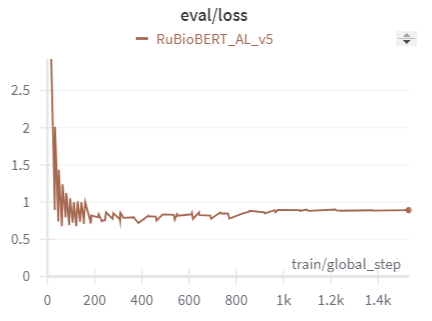   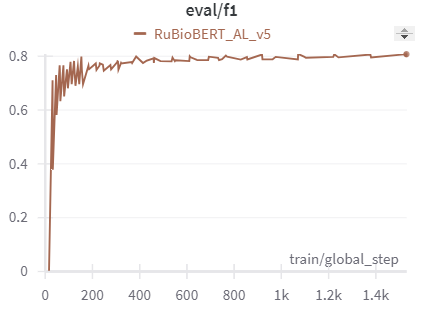

# Сэмплирование по 4 примера (по ~0.7% данных, 30 итераций активного обучения).
Циклы активного обучения завершены при достижении размера тренировочной выборки - 20%.

In [ ]:
config.run_name = "RuBioBERT_AL_v5_4"

In [ ]:
metrics, trainer = run_active_learning(
    dataset=tokenized_dataset, al_iters=30, init_train_size=0.007, choose_tokens=4,
    tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics
)

Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 0. Training using 4 samples


config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: Currently logged in as: taoea. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.891876,0.004331,0.005394,0.004805,0.008081
2,No log,3.630570,0.045587,0.044090,0.044826,0.124165
3,No log,3.424600,0.087273,0.039400,0.054290,0.179643
4,No log,3.281613,0.119302,0.028846,0.046459,0.179176
5,No log,3.193821,0.157012,0.024156,0.041870,0.177156
6,No log,3.136494,0.179487,0.026266,0.045827,0.179176
7,No log,3.097415,0.191860,0.030957,0.053312,0.183683
8,No log,3.073741,0.203046,0.037523,0.063341,0.189588
9,No log,3.062694,0.209166,0.041745,0.069599,0.192541
10,No log,3.059872,0.209249,0.042448,0.070579,0.193318


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 1. Training using 8 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.736575,0.017579,0.022514,0.019743,0.035742
2,No log,3.278299,0.117647,0.044559,0.064637,0.210412
3,No log,3.022720,0.193865,0.037054,0.062217,0.208702
4,No log,2.855521,0.246585,0.084662,0.126047,0.266822
5,No log,2.735631,0.287711,0.140009,0.188358,0.331002
6,No log,2.651330,0.302237,0.167917,0.215890,0.364258
7,No log,2.591296,0.316913,0.181051,0.230448,0.374204
8,2.709800,2.555235,0.320465,0.181051,0.231380,0.376224
9,2.709800,2.539500,0.322782,0.181754,0.232558,0.376690
10,2.709800,2.536155,0.322648,0.181754,0.232523,0.376690


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 2. Training using 12 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.589839,0.047078,0.054409,0.050479,0.110179
2,No log,3.064365,0.111776,0.013133,0.023505,0.190054
3,No log,2.861076,0.220000,0.036116,0.062047,0.226263
4,No log,2.701925,0.318553,0.128049,0.182670,0.327428
5,No log,2.567017,0.344507,0.173546,0.230817,0.378710
6,2.807400,2.452497,0.349570,0.200281,0.254659,0.406061
7,2.807400,2.365951,0.357504,0.232411,0.281694,0.438850
8,2.807400,2.312666,0.358428,0.252345,0.296174,0.461538
9,2.807400,2.289880,0.361175,0.259615,0.302088,0.467133
10,2.807400,2.285525,0.361301,0.260553,0.302766,0.468531


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 3. Training using 16 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.461619,0.088121,0.079503,0.083590,0.201709
2,No log,2.914935,0.132325,0.049250,0.071783,0.225330
3,No log,2.612181,0.318198,0.207083,0.250888,0.391453
4,2.869700,2.379650,0.354052,0.272514,0.307978,0.465734
5,2.869700,2.177535,0.414593,0.343809,0.375897,0.528361
6,2.869700,2.020001,0.446171,0.383912,0.412706,0.554468
7,2.869700,1.922522,0.470177,0.410413,0.438267,0.575602
8,1.513700,1.871378,0.478307,0.421435,0.448074,0.586946
9,1.513700,1.850634,0.483589,0.428471,0.454365,0.592696
10,1.513700,1.846891,0.484520,0.429409,0.455303,0.593629


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 4. Training using 20 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.353989,0.080243,0.034006,0.047768,0.200311
2,No log,2.840982,0.241650,0.028846,0.051540,0.197203
3,No log,2.511233,0.307717,0.227251,0.261433,0.429837
4,2.938600,2.218227,0.384174,0.314259,0.345717,0.505828
5,2.938600,2.001157,0.441434,0.378283,0.407426,0.553380
6,2.938600,1.839034,0.482039,0.428002,0.453416,0.593318
7,1.511000,1.743957,0.519191,0.469512,0.493103,0.624864
8,1.511000,1.698137,0.536994,0.488508,0.511605,0.639938
9,1.511000,1.682261,0.543070,0.495310,0.518092,0.644134
10,1.001300,1.678639,0.543115,0.494841,0.517855,0.644289


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 5. Training using 24 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.299155,0.118726,0.092636,0.104071,0.241026
2,No log,2.752508,0.278677,0.096857,0.143752,0.287801
3,3.066300,2.399408,0.335826,0.242261,0.281471,0.434654
4,3.066300,2.087403,0.392624,0.324578,0.355373,0.508625
5,3.066300,1.829811,0.478555,0.431754,0.453951,0.598912
6,1.635900,1.677467,0.531518,0.494371,0.512272,0.636053
7,1.635900,1.615521,0.546667,0.509615,0.527491,0.651748
8,0.941800,1.558023,0.563899,0.531895,0.547429,0.665113
9,0.941800,1.538608,0.566939,0.537289,0.551716,0.669619
10,0.941800,1.535750,0.567788,0.538227,0.552613,0.670396


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 6. Training using 28 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.137192,0.054250,0.007036,0.012456,0.163947
2,No log,2.737041,0.247895,0.124296,0.165573,0.301787
3,3.095100,2.315937,0.367045,0.273218,0.313256,0.474592
4,3.095100,1.952597,0.431706,0.369137,0.397977,0.554312
5,1.743800,1.758756,0.489207,0.441135,0.463929,0.603419
6,1.743800,1.648709,0.516773,0.473265,0.494063,0.626729
7,0.997900,1.572676,0.545161,0.515244,0.529781,0.653302
8,0.997900,1.544311,0.559073,0.526032,0.542049,0.660295
9,0.997900,1.534343,0.560020,0.526266,0.542619,0.661072
10,0.718800,1.532021,0.560599,0.527205,0.543389,0.662005


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 7. Training using 32 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.117025,0.135302,0.071998,0.093984,0.218493
2,3.141000,2.659440,0.299406,0.165572,0.213229,0.370319
3,3.141000,2.168196,0.378246,0.290338,0.328513,0.491531
4,1.818400,1.786998,0.473558,0.415807,0.442807,0.593007
5,1.818400,1.587876,0.545572,0.494137,0.518582,0.647242
6,0.998300,1.468495,0.584920,0.540338,0.561746,0.679720
7,0.998300,1.399829,0.607735,0.567542,0.586951,0.698368
8,0.682000,1.375994,0.608641,0.571529,0.589502,0.701632
9,0.682000,1.367556,0.614382,0.575047,0.594064,0.704118
10,0.586700,1.365092,0.614289,0.576689,0.594895,0.704429


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 8. Training using 36 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.066642,0.052632,0.006098,0.010929,0.168609
2,3.208000,2.508470,0.329829,0.257505,0.289214,0.458120
3,3.208000,1.940110,0.460849,0.409944,0.433908,0.574359
4,1.761000,1.659911,0.516153,0.479597,0.497204,0.625019
5,1.761000,1.552275,0.559461,0.526266,0.542356,0.660761
6,1.025200,1.412929,0.594139,0.570591,0.582127,0.687490
7,1.025200,1.361893,0.608643,0.587946,0.598115,0.698679
8,0.729700,1.325555,0.616602,0.594043,0.605112,0.707226
9,0.583800,1.316643,0.622293,0.599672,0.610773,0.710645
10,0.583800,1.316168,0.622201,0.599437,0.610607,0.710645


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 9. Training using 40 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.005825,0.178815,0.036820,0.061066,0.208236
2,3.189700,2.423589,0.387539,0.291745,0.332887,0.489977
3,3.189700,1.843827,0.476126,0.413931,0.442855,0.583528
4,1.904900,1.555351,0.566028,0.533771,0.549427,0.661228
5,1.075100,1.431399,0.595849,0.572233,0.583802,0.689510
6,1.075100,1.350712,0.611462,0.590525,0.600811,0.703186
7,0.733200,1.305180,0.626200,0.612101,0.619070,0.715462
8,0.592200,1.277314,0.633725,0.619606,0.626586,0.721057
9,0.592200,1.268372,0.635599,0.620544,0.627981,0.721678
10,0.530600,1.266800,0.636647,0.621717,0.629093,0.722922


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 10. Training using 44 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.967162,0.086606,0.020169,0.032718,0.186791
2,3.300700,2.330088,0.376984,0.245075,0.297044,0.439316
3,1.948400,1.761694,0.511929,0.462946,0.486207,0.619580
4,1.948400,1.500750,0.571752,0.533537,0.551984,0.666977
5,1.133600,1.346538,0.620607,0.604597,0.612497,0.709868
6,0.783500,1.271076,0.616097,0.608583,0.612317,0.716084
7,0.783500,1.195415,0.647850,0.632505,0.640085,0.735198
8,0.579600,1.176611,0.655690,0.635084,0.645223,0.741725
9,0.454700,1.165124,0.666182,0.644934,0.655386,0.748096
10,0.454700,1.164297,0.667796,0.647280,0.657378,0.749029


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 11. Training using 48 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.965334,0.023377,0.002111,0.003872,0.165190
2,3.290100,2.293930,0.399338,0.311210,0.349809,0.501632
3,2.035200,1.662019,0.550811,0.517355,0.533559,0.647708
4,1.221500,1.383863,0.607384,0.590291,0.598716,0.696970
5,1.221500,1.256985,0.629779,0.621951,0.625841,0.720901
6,0.778900,1.175605,0.654628,0.641886,0.648194,0.744056
7,0.540900,1.128650,0.673666,0.654550,0.663971,0.756333
8,0.446500,1.110725,0.677856,0.658302,0.667936,0.758042
9,0.446500,1.111571,0.681247,0.661116,0.671031,0.758508
10,0.406400,1.109500,0.681566,0.661585,0.671427,0.758974


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 12. Training using 52 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.940728,0.000000,0.000000,0.000000,0.158042
2,3.355400,2.220490,0.384083,0.312383,0.344542,0.495105
3,2.128100,1.638990,0.522906,0.484522,0.502982,0.625175
4,1.328100,1.347159,0.611796,0.593574,0.602547,0.702720
5,0.834100,1.208019,0.635016,0.622655,0.628774,0.727117
6,0.834100,1.135898,0.658339,0.648921,0.653596,0.746853
7,0.573400,1.104148,0.668330,0.659709,0.663992,0.756022
8,0.447800,1.080686,0.678144,0.665103,0.671561,0.762859
9,0.423000,1.072075,0.678862,0.665807,0.672271,0.764413
10,0.360800,1.071106,0.679570,0.666979,0.673216,0.764413


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 13. Training using 56 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.913762,0.164134,0.012664,0.023514,0.175913
2,3.323300,2.020466,0.456797,0.406660,0.430273,0.563170
3,2.097800,1.482520,0.585504,0.558865,0.571874,0.677545
4,1.144700,1.292579,0.629230,0.614916,0.621990,0.718570
5,0.784700,1.186859,0.644718,0.626876,0.635672,0.727273
6,0.533400,1.128715,0.668576,0.657129,0.662803,0.751360
7,0.453800,1.085397,0.689257,0.672608,0.680831,0.768765
8,0.369900,1.072486,0.695820,0.675422,0.685469,0.772028
9,0.369900,1.060686,0.696537,0.674484,0.685333,0.774670
10,0.325000,1.059431,0.696126,0.674250,0.685013,0.774825


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 14. Training using 60 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.867277,0.076316,0.006801,0.012489,0.179643
2,3.346800,1.977894,0.452501,0.358583,0.400105,0.549340
3,2.144900,1.430432,0.599497,0.558865,0.578468,0.683139
4,1.282000,1.250367,0.635965,0.612101,0.623805,0.722145
5,0.786000,1.148552,0.663155,0.634850,0.648694,0.742502
6,0.632500,1.094282,0.674300,0.649156,0.661489,0.754468
7,0.477500,1.045190,0.696258,0.667683,0.681671,0.772650
8,0.376200,1.032978,0.703477,0.673780,0.688309,0.777156
9,0.346100,1.027983,0.704584,0.674015,0.688961,0.776535
10,0.305100,1.026698,0.706055,0.675422,0.690399,0.777622


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 15. Training using 64 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.312900,2.854782,0.108869,0.060741,0.077977,0.241803
2,2.224000,1.902180,0.468344,0.397280,0.429895,0.576379
3,1.329600,1.425943,0.594940,0.568011,0.581164,0.688578
4,0.859300,1.207808,0.639422,0.632974,0.636181,0.728050
5,0.604000,1.098881,0.675500,0.657598,0.666429,0.761305
6,0.457600,1.081091,0.680959,0.659240,0.669924,0.763481
7,0.361700,1.051661,0.683834,0.672608,0.678175,0.772183
8,0.314200,1.020131,0.694989,0.673311,0.683979,0.777001
9,0.284400,1.013538,0.699081,0.677767,0.688259,0.778555
10,0.277100,1.011436,0.700048,0.678705,0.689212,0.778866


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 16. Training using 68 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.381800,2.773268,0.243538,0.099437,0.141216,0.278322
2,2.142800,1.722032,0.515152,0.470450,0.491787,0.616783
3,1.243800,1.302966,0.630581,0.616088,0.623250,0.719347
4,0.777000,1.122091,0.655899,0.642824,0.649295,0.736131
5,0.600400,1.049453,0.675399,0.665103,0.670212,0.760839
6,0.415300,0.995636,0.707034,0.685976,0.696346,0.781818
7,0.337700,0.966000,0.719863,0.691839,0.705573,0.791919
8,0.299300,0.964132,0.719765,0.690901,0.705038,0.788811
9,0.240100,0.951664,0.719290,0.693480,0.706149,0.789744
10,0.262000,0.948268,0.720964,0.694418,0.707442,0.790676


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 17. Training using 72 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.396700,2.789503,0.262329,0.058630,0.095841,0.241336
2,2.230000,1.772810,0.528892,0.463649,0.494126,0.618337
3,1.389700,1.360603,0.636386,0.614447,0.625224,0.717327
4,0.865700,1.185341,0.654975,0.643762,0.649320,0.736597
5,0.660700,1.099511,0.686663,0.673780,0.680161,0.762238
6,0.482300,1.019297,0.710750,0.686914,0.698629,0.783372
7,0.386600,1.008562,0.713705,0.699812,0.706690,0.787879
8,0.294600,0.979109,0.723219,0.699812,0.711323,0.792230
9,0.258600,0.977444,0.721550,0.698874,0.710031,0.793162
10,0.252700,0.977169,0.721026,0.698874,0.709777,0.793162


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 18. Training using 76 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.398500,2.780031,0.218116,0.156426,0.182191,0.354623
2,2.402000,1.715048,0.529506,0.465056,0.495193,0.625486
3,1.393900,1.314390,0.637430,0.611867,0.624387,0.713753
4,0.967900,1.143189,0.660531,0.647983,0.654197,0.740171
5,0.685600,1.053570,0.672920,0.656191,0.664450,0.750427
6,0.400500,0.997450,0.693599,0.668386,0.680760,0.772650
7,0.328700,0.966303,0.711642,0.685272,0.698208,0.786169
8,0.282300,0.951758,0.715538,0.689024,0.702031,0.790521
9,0.239000,0.951412,0.719524,0.694887,0.706991,0.792385
10,0.216700,0.950419,0.720078,0.695591,0.707623,0.793162


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 19. Training using 80 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.450400,2.654379,0.300685,0.205910,0.244432,0.388811
2,2.287700,1.635851,0.567595,0.525797,0.545897,0.656099
3,1.350200,1.270933,0.644273,0.625235,0.634611,0.723232
4,0.656600,1.097023,0.671349,0.650094,0.660550,0.747475
5,0.528700,0.987490,0.706567,0.683865,0.695030,0.779487
6,0.384300,0.939360,0.721817,0.696764,0.709069,0.792075
7,0.323700,0.906456,0.733594,0.705206,0.719120,0.799534
8,0.246600,0.903255,0.729383,0.707317,0.718181,0.799223
9,0.211900,0.903814,0.734061,0.710131,0.721898,0.801088
10,0.200700,0.903602,0.733769,0.710366,0.721878,0.801554


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 20. Training using 84 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.441500,2.805945,0.192626,0.142120,0.163563,0.285470
2,2.478900,1.670584,0.556054,0.523452,0.539261,0.656410
3,1.532100,1.348338,0.609909,0.594747,0.602232,0.697280
4,0.765800,1.140848,0.652988,0.638133,0.645475,0.739394
5,0.576200,1.010893,0.708515,0.686914,0.697547,0.783217
6,0.467000,0.952759,0.717576,0.694184,0.705686,0.790210
7,0.298500,0.935022,0.725647,0.704034,0.714677,0.796581
8,0.250800,0.913608,0.724764,0.702158,0.713282,0.797824
9,0.231400,0.912909,0.730332,0.707552,0.718761,0.801243
10,0.217700,0.912451,0.729540,0.706614,0.717894,0.800932


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 21. Training using 88 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.458900,2.785025,0.250000,0.174015,0.205199,0.368765
2,2.438400,1.583086,0.570549,0.521576,0.544964,0.659518
3,0.963700,1.246858,0.635268,0.605769,0.620168,0.714996
4,0.730100,1.118525,0.662422,0.646576,0.654403,0.749806
5,0.584900,0.950283,0.715049,0.690901,0.702767,0.787879
6,0.369300,0.906397,0.720835,0.704268,0.712456,0.794406
7,0.316100,0.876568,0.735541,0.718809,0.727079,0.805905
8,0.228200,0.871186,0.728894,0.718809,0.723816,0.804973
9,0.223200,0.862673,0.732411,0.720216,0.726262,0.807770
10,0.197100,0.866080,0.732744,0.719512,0.726068,0.807304


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 22. Training using 92 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.528200,2.632002,0.306659,0.246248,0.273153,0.443823
2,2.441900,1.533917,0.569420,0.531895,0.550018,0.664957
3,0.983200,1.171523,0.637890,0.623827,0.630780,0.727894
4,0.732100,0.998725,0.700120,0.682223,0.691056,0.779487
5,0.427000,0.931947,0.715457,0.695826,0.705505,0.791608
6,0.358600,0.888837,0.721718,0.709193,0.715401,0.800000
7,0.254100,0.867830,0.730843,0.715760,0.723223,0.804817
8,0.216300,0.867325,0.734572,0.723030,0.728755,0.808236
9,0.201200,0.872661,0.732779,0.723499,0.728110,0.807148
10,0.186900,0.872722,0.733873,0.723030,0.728411,0.807459


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 23. Training using 96 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.518800,2.586547,0.312705,0.223968,0.261000,0.409790
2,1.586800,1.513420,0.587048,0.559099,0.572733,0.680031
3,1.010700,1.176365,0.639480,0.634381,0.636920,0.729604
4,0.610300,1.028886,0.679554,0.671904,0.675708,0.764413
5,0.458500,0.946855,0.696349,0.693246,0.694794,0.782906
6,0.358500,0.888849,0.728721,0.718809,0.723731,0.804040
7,0.290300,0.863057,0.734334,0.722795,0.728519,0.807770
8,0.219200,0.885704,0.729640,0.722795,0.726202,0.804973
9,0.192600,0.872889,0.736405,0.727251,0.731799,0.809479
10,0.184800,0.872798,0.736805,0.726782,0.731759,0.809324


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 24. Training using 100 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.455900,2.576314,0.297333,0.211773,0.247363,0.408081
2,1.581500,1.483603,0.572493,0.540807,0.556199,0.668687
3,1.034000,1.151790,0.641819,0.632036,0.636890,0.731779
4,0.599200,1.008648,0.701023,0.674719,0.687620,0.766123
5,0.437000,0.932506,0.715102,0.704034,0.709525,0.789588
6,0.327800,0.894131,0.733382,0.714118,0.723622,0.800311
7,0.276200,0.865434,0.730340,0.720919,0.725599,0.803574
8,0.201600,0.881686,0.734704,0.720919,0.727746,0.803885
9,0.178000,0.877331,0.732317,0.721154,0.726693,0.805594
10,0.183300,0.876523,0.732683,0.721857,0.727230,0.806216


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 25. Training using 104 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.528000,2.539304,0.296574,0.241557,0.266253,0.422999
2,1.534900,1.425776,0.603891,0.567777,0.585277,0.690443
3,1.002800,1.129491,0.670195,0.653377,0.661679,0.746232
4,0.605400,0.975921,0.705218,0.687852,0.696426,0.773582
5,0.398200,0.897970,0.723589,0.703565,0.713436,0.795804
6,0.332200,0.883447,0.731468,0.717402,0.724367,0.804662
7,0.251800,0.850061,0.732199,0.716229,0.724126,0.806993
8,0.187300,0.872974,0.737631,0.727251,0.732404,0.809946
9,0.168000,0.860442,0.740114,0.728659,0.734342,0.811655
10,0.161400,0.857118,0.737280,0.727251,0.732231,0.810723


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 26. Training using 108 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.541200,2.586395,0.274270,0.231238,0.250923,0.400155
2,1.617500,1.410631,0.612766,0.574109,0.592808,0.697747
3,0.852200,1.156986,0.662156,0.642589,0.652226,0.739860
4,0.626500,0.972771,0.709709,0.685741,0.697519,0.779176
5,0.391200,0.908771,0.725589,0.707552,0.716457,0.794872
6,0.310900,0.837789,0.741787,0.720216,0.730842,0.809013
7,0.239500,0.844515,0.742947,0.722561,0.732612,0.807615
8,0.202000,0.834463,0.742570,0.726548,0.734471,0.812277
9,0.164400,0.841741,0.743946,0.727720,0.735744,0.812277
10,0.155600,0.841050,0.745023,0.728424,0.736630,0.812743


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 27. Training using 112 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.507200,2.460754,0.353320,0.283302,0.314460,0.462160
2,1.479000,1.348731,0.627935,0.602017,0.614703,0.712044
3,0.803500,1.052363,0.678519,0.653377,0.665711,0.756177
4,0.532100,0.898039,0.729100,0.697467,0.712933,0.801554
5,0.405500,0.837452,0.743764,0.720216,0.731800,0.813831
6,0.282300,0.830149,0.747404,0.725844,0.736466,0.816939
7,0.229900,0.830845,0.748028,0.733818,0.740855,0.816939
8,0.175000,0.811521,0.751261,0.733818,0.742437,0.820668
9,0.162700,0.820650,0.753609,0.734522,0.743943,0.821134
10,0.167800,0.822601,0.752585,0.734053,0.743203,0.820668


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 28. Training using 116 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.540900,2.457069,0.352922,0.257739,0.297913,0.454390
2,1.639300,1.377537,0.614395,0.582552,0.598050,0.700233
3,0.822500,1.089726,0.666588,0.659240,0.662894,0.745921
4,0.488200,0.922361,0.722371,0.694418,0.708119,0.792385
5,0.330100,0.865233,0.741827,0.723734,0.732669,0.812121
6,0.285300,0.841828,0.749284,0.736632,0.742904,0.817249
7,0.201500,0.815780,0.737345,0.724203,0.730715,0.812277
8,0.158500,0.817298,0.744252,0.736398,0.740304,0.817094
9,0.150200,0.819871,0.745775,0.734756,0.740224,0.817405
10,0.131100,0.821705,0.746134,0.735460,0.740758,0.817716


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 29. Training using 120 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.506200,2.457938,0.308844,0.212946,0.252082,0.420357
2,1.769400,1.365109,0.597501,0.571998,0.584472,0.692152
3,0.883300,1.089898,0.661094,0.649156,0.655070,0.744211
4,0.584000,0.915066,0.718097,0.700750,0.709318,0.793473
5,0.418400,0.860940,0.734037,0.717167,0.725504,0.804196
6,0.294500,0.827986,0.745013,0.727017,0.735905,0.811033
7,0.228300,0.807450,0.748559,0.731004,0.739677,0.818959
8,0.168400,0.795570,0.751077,0.735929,0.743426,0.820824
9,0.156500,0.805323,0.748148,0.734287,0.741153,0.818959
10,0.166200,0.805084,0.748685,0.734287,0.741416,0.820047


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

In [ ]:
wandb.finish()

eval/accuracy,▂▁▄▄▄▆▆▆▃▇▇▆▃▅▇▇▇▂█▇▇██▇▆████▇███▄██▇███
eval/f1,▁▁▃▃▃▅▆▅▂▆▆▆▁▄▇▇▇▁▇▇▆▇█▇▆████▆██▇▃██▇███
eval/loss,▇█▅▅▅▃▃▃▆▃▂▃▆▅▂▂▂▆▂▂▂▁▁▂▃▁▁▁▁▃▁▁▁▅▁▁▂▁▁▁
eval/precision,▂▁▄▄▄▅▆▅▃▆▇▆▃▄▇▇▇▂▇▇▆▇█▇▆████▆███▄██▇███
eval/recall,▁▁▃▃▃▅▆▅▂▆▆▆▁▃▇▇▇▁▇▇▆▇█▇▅████▆██▇▃██▇███
eval/runtime,▂▁▁▃▁▁▁▂▆█▁▁▁▁▁▁▂▆▁▂▆▁▂▂▂▆▁▆▂▂▂▂▂▆▂▁▇▁▁▇
eval/samples_per_second,▇██▆▇▇█▇▂▁███▇█▇▇▃▇▇▃▇▆▇▆▃█▂▇▇▇▇▇▃▇▇▂▇▇▂
eval/steps_per_second,▇██▆▇▇█▇▂▁███▇█▇▇▃▇▇▃▇▆▇▆▃█▂▇▇▇▇▇▃▇▇▂▇▇▂
train/epoch,▆█▂▃▃▄▃▃▃▁█▇▆▄▃█▆▄▂█▅▃█▅▂▇▄▁▆▃▇▄█▅▂▆▂▇▃▇
train/global_step,▁▁▁▁▁▂▂▂▂▁▄▄▃▃▂▅▄▃▂▅▄▂▆▄▂▆▄▁▅▃▇▄█▅▂▆▃▇▃█
train/grad_norm,▃▄▅▁▃▂▄▄▄▂▃▄▄█▄▂▆▃▅▄▅▁▂▅▄▃▄▁▅▄▄▁▃▄▂▃▃▄▅▁


In [ ]:
import json
with open('/content/drive/MyDrive/data/VKR/metrics_30_random_seed64.json', 'w') as file:
    json.dump(metrics, file)

# Сэмплирование по 1 примеру (20 итераций активного обучения).
Циклы активного обучения завершены на 20 примерах (3,3% данных).

In [ ]:
config.run_name = "RuBioBERT_AL_v5_5"
config.train_batch_size = 1
config.eval_batch_size = 1

In [ ]:
metrics, trainer = run_active_learning(
    dataset=tokenized_dataset, al_iters=20, init_train_size=0.002, choose_tokens=1,
    tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics
)

Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 0. Training using 1 samples


config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: Currently logged in as: taoea. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.888201,0.004331,0.005394,0.004805,0.008081
2,No log,3.703049,0.034063,0.035413,0.034725,0.089200
3,No log,3.556926,0.062207,0.046670,0.053330,0.146698
4,No log,3.457636,0.072233,0.051126,0.059874,0.162238
5,No log,3.398059,0.077250,0.055347,0.064490,0.183838
6,No log,3.361694,0.081836,0.059803,0.069106,0.199068
7,No log,3.338506,0.086817,0.063321,0.073230,0.208392
8,No log,3.324728,0.091343,0.067308,0.077505,0.212277
9,No log,3.318352,0.095525,0.070591,0.081187,0.215385
10,No log,3.316709,0.097530,0.072233,0.082996,0.216628


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 1. Training using 2 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.802290,0.014898,0.017120,0.015932,0.029526
2,No log,3.463038,0.050457,0.037523,0.043040,0.160062
3,No log,3.270855,0.068778,0.017824,0.028311,0.179953
4,No log,3.179264,0.075738,0.013837,0.023399,0.178555
5,No log,3.116551,0.144828,0.039400,0.061947,0.203108
6,No log,3.071875,0.174057,0.061679,0.091082,0.225952
7,No log,3.042489,0.192993,0.076220,0.109280,0.241026
8,2.480600,3.024934,0.195053,0.081379,0.114844,0.249262
9,2.480600,3.016935,0.197820,0.085131,0.119036,0.253613
10,2.480600,3.015239,0.197068,0.085131,0.118899,0.254235


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 2. Training using 3 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.665401,0.047080,0.055582,0.050979,0.095571
2,No log,3.231121,0.080738,0.016417,0.027285,0.178089
3,No log,3.054734,0.179894,0.055816,0.085198,0.218026
4,No log,2.935334,0.233292,0.131801,0.168440,0.296503
5,No log,2.820961,0.250432,0.170028,0.202542,0.345921
6,2.622800,2.729748,0.272441,0.182927,0.218886,0.368454
7,2.622800,2.667082,0.281847,0.190432,0.227292,0.376068
8,2.622800,2.630491,0.288409,0.197233,0.234262,0.383838
9,2.622800,2.614734,0.295400,0.203330,0.240867,0.389433
10,2.622800,2.611711,0.294258,0.203096,0.240322,0.389744


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 3. Training using 4 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.571515,0.039378,0.043386,0.041285,0.109713
2,No log,3.155647,0.085551,0.021107,0.033860,0.178244
3,No log,2.985485,0.163209,0.055347,0.082662,0.229681
4,2.793000,2.828755,0.224338,0.162992,0.188807,0.346076
5,2.793000,2.681297,0.253355,0.185976,0.214498,0.376068
6,2.793000,2.568921,0.285940,0.211773,0.243331,0.399378
7,2.793000,2.490811,0.312777,0.248593,0.277016,0.437141
8,1.329300,2.445367,0.326459,0.263602,0.291683,0.449728
9,1.329300,2.425819,0.328547,0.268293,0.295378,0.455478
10,1.329300,2.422280,0.329503,0.268996,0.296191,0.456255


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 4. Training using 5 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.499840,0.078868,0.079737,0.079300,0.171717
2,No log,3.059718,0.160092,0.081848,0.108318,0.243201
3,No log,2.830026,0.186452,0.135553,0.156980,0.307537
4,2.944800,2.628160,0.251984,0.178705,0.209111,0.361927
5,2.944800,2.456052,0.290535,0.238274,0.261822,0.413831
6,2.944800,2.329432,0.346102,0.300891,0.321917,0.466977
7,1.422600,2.247070,0.385624,0.344747,0.364042,0.503963
8,1.422600,2.201532,0.399165,0.358818,0.377918,0.516239
9,1.422600,2.183101,0.408937,0.369137,0.388019,0.523699
10,0.813800,2.179845,0.409197,0.369371,0.388266,0.524165


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 5. Training using 6 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.402377,0.078603,0.054878,0.064632,0.195183
2,No log,2.960094,0.227363,0.080675,0.119093,0.253768
3,2.973500,2.720946,0.299748,0.195356,0.236547,0.378399
4,2.973500,2.483687,0.332155,0.264540,0.294517,0.442113
5,2.973500,2.284317,0.387172,0.349672,0.367468,0.502564
6,1.462300,2.131564,0.413021,0.380863,0.396291,0.528671
7,1.462300,2.054257,0.435930,0.406895,0.420912,0.549340
8,0.735700,2.013774,0.446451,0.417448,0.431463,0.560995
9,0.735700,1.996280,0.447836,0.419794,0.433362,0.564569
10,0.735700,1.993533,0.449087,0.420966,0.434572,0.565967


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 6. Training using 7 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.337509,0.124063,0.077627,0.095499,0.222533
2,No log,2.922890,0.253465,0.090056,0.132895,0.245998
3,3.098700,2.629415,0.299699,0.233349,0.262395,0.400622
4,3.098700,2.337136,0.368106,0.331848,0.349038,0.490598
5,1.644100,2.108508,0.438859,0.425891,0.432278,0.554934
6,1.644100,1.978010,0.460260,0.448171,0.454135,0.575291
7,0.792800,1.908420,0.482040,0.472092,0.477014,0.591919
8,0.792800,1.878885,0.491839,0.480535,0.486121,0.601088
9,0.792800,1.865739,0.495794,0.483818,0.489733,0.604662
10,0.548600,1.863744,0.496270,0.483583,0.489844,0.605128


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 7. Training using 8 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.221411,0.090084,0.032598,0.047873,0.191608
2,3.127600,2.842885,0.214459,0.124531,0.157567,0.303341
3,3.127600,2.564079,0.307716,0.235694,0.266932,0.412432
4,1.799300,2.279152,0.382234,0.333021,0.355934,0.493706
5,1.799300,2.031179,0.469604,0.447467,0.458268,0.586946
6,0.898300,1.904926,0.506459,0.487336,0.496713,0.615851
7,0.898300,1.825875,0.528169,0.510084,0.518969,0.636674
8,0.533300,1.802513,0.531630,0.512430,0.521853,0.639938
9,0.533300,1.792989,0.534663,0.515478,0.524896,0.641026
10,0.438400,1.790211,0.534600,0.514540,0.524379,0.640870


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 8. Training using 9 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.187483,0.073871,0.025328,0.037723,0.183217
2,3.195900,2.775863,0.249425,0.152674,0.189409,0.335820
3,3.195900,2.383662,0.363149,0.318011,0.339085,0.489355
4,1.827000,2.030575,0.461142,0.441135,0.450917,0.578089
5,1.827000,1.880646,0.484348,0.453565,0.468451,0.593473
6,0.869500,1.723521,0.537361,0.511023,0.523861,0.643667
7,0.869500,1.689547,0.546526,0.522045,0.534005,0.649573
8,0.489900,1.685071,0.544807,0.520403,0.532326,0.648640
9,0.358600,1.677645,0.547730,0.523452,0.535316,0.650350
10,0.358600,1.674488,0.547707,0.523687,0.535427,0.650350


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 9. Training using 10 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.181029,0.137062,0.052298,0.075709,0.205905
2,3.225400,2.700530,0.289213,0.232645,0.257863,0.404040
3,3.225400,2.201202,0.424154,0.373124,0.397006,0.535664
4,1.771700,1.958349,0.482862,0.416276,0.447103,0.584305
5,0.895100,1.747214,0.545758,0.497889,0.520726,0.643046
6,0.895100,1.694577,0.563692,0.519934,0.540930,0.659829
7,0.491900,1.651993,0.570777,0.528612,0.548886,0.664336
8,0.379600,1.616485,0.580816,0.541041,0.560223,0.672261
9,0.379600,1.612956,0.581951,0.542917,0.561757,0.673815
10,0.292600,1.612959,0.582390,0.542917,0.561961,0.673660


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 10. Training using 11 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.121714,0.022936,0.001173,0.002231,0.157420
2,3.278500,2.677452,0.309906,0.239916,0.270456,0.417405
3,2.014900,2.167604,0.389955,0.324109,0.353996,0.500233
4,2.014900,1.846171,0.507662,0.481707,0.494344,0.617249
5,1.047500,1.670699,0.566794,0.520403,0.542609,0.653924
6,0.696800,1.631801,0.563859,0.529081,0.545917,0.658741
7,0.696800,1.593553,0.571216,0.538931,0.554604,0.664802
8,0.421000,1.559736,0.584203,0.551595,0.567431,0.672727
9,0.395400,1.563917,0.583416,0.549484,0.565942,0.673815
10,0.395400,1.561485,0.584141,0.551126,0.567153,0.673660


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 11. Training using 12 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.098617,0.009967,0.000704,0.001314,0.156954
2,3.279400,2.701170,0.240397,0.176126,0.203303,0.359130
3,2.187000,2.141539,0.407994,0.368668,0.387335,0.530536
4,1.213400,1.848425,0.494230,0.462008,0.477576,0.598757
5,1.213400,1.770907,0.514432,0.472326,0.492481,0.619270
6,0.694800,1.633530,0.560921,0.525797,0.542791,0.663248
7,0.505400,1.583778,0.558723,0.537758,0.548040,0.665734
8,0.354900,1.553090,0.579180,0.553236,0.565911,0.680031
9,0.354900,1.544457,0.583621,0.554878,0.568887,0.683761
10,0.319600,1.543919,0.584854,0.556051,0.570089,0.684227


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 12. Training using 13 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.052687,0.102564,0.019700,0.033051,0.182595
2,3.303100,2.529599,0.320870,0.245544,0.278198,0.424242
3,2.185100,1.984198,0.455076,0.420497,0.437104,0.562704
4,1.251900,1.803026,0.487293,0.440666,0.462808,0.596737
5,0.696500,1.617603,0.546206,0.526735,0.536294,0.659518
6,0.696500,1.596074,0.557501,0.537758,0.547451,0.664491
7,0.503400,1.513713,0.580465,0.561679,0.570918,0.681740
8,0.381600,1.497394,0.585336,0.565432,0.575212,0.686247
9,0.342900,1.495176,0.583636,0.565432,0.574390,0.685936
10,0.297000,1.494576,0.583696,0.565901,0.574661,0.686558


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 13. Training using 14 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.046889,0.078125,0.007036,0.012909,0.167988
2,3.372300,2.533367,0.288859,0.200047,0.236386,0.402176
3,2.288600,1.995253,0.423910,0.390009,0.406254,0.542191
4,1.393700,1.710958,0.501498,0.471154,0.485852,0.617094
5,0.843700,1.608897,0.533367,0.498593,0.515394,0.638695
6,0.564800,1.530713,0.553119,0.532364,0.542543,0.661694
7,0.450800,1.436479,0.586904,0.565432,0.575968,0.687179
8,0.330800,1.482034,0.570698,0.549953,0.560134,0.676301
9,0.330800,1.481614,0.570628,0.549484,0.559857,0.676301
10,0.279100,1.473572,0.574038,0.552767,0.563202,0.679254


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 14. Training using 15 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.063022,0.000000,0.000000,0.000000,0.155556
2,3.440800,2.405205,0.361003,0.303940,0.330023,0.480031
3,2.280800,1.824245,0.497534,0.449578,0.472342,0.592852
4,1.439700,1.567589,0.564597,0.528846,0.546137,0.659052
5,0.778600,1.441193,0.596678,0.564493,0.580140,0.688889
6,0.591500,1.352261,0.605341,0.574109,0.589312,0.700699
7,0.397000,1.321998,0.612029,0.582317,0.596803,0.706760
8,0.348800,1.316122,0.618824,0.587477,0.602743,0.713753
9,0.263200,1.324144,0.621006,0.587946,0.604024,0.714841
10,0.245600,1.322197,0.621280,0.587477,0.603905,0.715618


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 15. Training using 16 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.464100,3.039544,0.018692,0.000469,0.000915,0.155556
2,2.444100,2.506934,0.274706,0.186445,0.222129,0.387413
3,1.645400,1.971669,0.423468,0.380863,0.401037,0.537374
4,0.968400,1.637360,0.525720,0.500938,0.513030,0.632479
5,0.604600,1.493009,0.554574,0.530253,0.542141,0.662782
6,0.446900,1.366020,0.592326,0.579268,0.585724,0.695726
7,0.334200,1.383164,0.585599,0.560741,0.572900,0.693551
8,0.270600,1.353953,0.603260,0.581614,0.592239,0.705517
9,0.237000,1.340636,0.609951,0.589353,0.599475,0.711422
10,0.228100,1.341064,0.608917,0.589353,0.598975,0.711577


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 16. Training using 17 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.431100,2.976889,0.151899,0.005629,0.010855,0.160995
2,2.192300,2.222990,0.384425,0.327627,0.353760,0.503963
3,1.480400,1.731949,0.523955,0.482176,0.502198,0.628904
4,0.808000,1.545038,0.567889,0.526735,0.546539,0.671018
5,0.623800,1.444263,0.582882,0.555816,0.569028,0.685470
6,0.475200,1.382264,0.600248,0.567308,0.583313,0.698368
7,0.344500,1.323593,0.607824,0.583021,0.595164,0.706760
8,0.275000,1.310966,0.627131,0.595216,0.610757,0.717327
9,0.203500,1.306377,0.628310,0.595450,0.611439,0.719192
10,0.229500,1.305204,0.629136,0.597561,0.612942,0.719658


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 17. Training using 18 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.530400,2.995323,0.223529,0.022280,0.040520,0.184149
2,2.511200,2.233435,0.412978,0.352251,0.380205,0.522300
3,1.590500,1.677358,0.539674,0.489681,0.513464,0.643357
4,0.913100,1.471824,0.598616,0.568011,0.582912,0.690287
5,0.761600,1.366386,0.610918,0.577392,0.593682,0.702720
6,0.482500,1.337321,0.630773,0.589353,0.609360,0.718260
7,0.376600,1.282232,0.648609,0.617730,0.632793,0.729604
8,0.242900,1.254351,0.664674,0.625704,0.644600,0.741570
9,0.199900,1.260305,0.666917,0.625938,0.645778,0.742657
10,0.165000,1.260141,0.667166,0.626642,0.646269,0.742968


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 18. Training using 19 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.500100,2.991628,0.031250,0.001876,0.003540,0.162082
2,2.440400,2.182689,0.448647,0.400563,0.423244,0.571096
3,1.599100,1.661499,0.559305,0.520872,0.539405,0.655633
4,1.047000,1.473926,0.582716,0.553471,0.567717,0.677078
5,0.768800,1.361417,0.618437,0.588415,0.603053,0.702564
6,0.373700,1.308702,0.624727,0.603189,0.613769,0.717793
7,0.284700,1.248205,0.646915,0.622186,0.634310,0.733644
8,0.253900,1.243227,0.653818,0.624531,0.638839,0.735198
9,0.164100,1.239101,0.658771,0.626173,0.642058,0.738151
10,0.220700,1.236279,0.657629,0.625704,0.641269,0.738151


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 19. Training using 20 samples


Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.537800,2.982466,0.110397,0.068480,0.084527,0.230148
2,2.488100,2.209963,0.370670,0.311210,0.338348,0.491997
3,1.772200,1.643863,0.544805,0.500469,0.521697,0.644911
4,0.790800,1.473911,0.569352,0.541979,0.555329,0.674592
5,0.566200,1.326954,0.629968,0.598499,0.613830,0.719969
6,0.479200,1.301092,0.628422,0.592167,0.609756,0.714841
7,0.313000,1.254974,0.643190,0.614681,0.628613,0.730381
8,0.230200,1.209930,0.656120,0.627345,0.641410,0.740948
9,0.209900,1.215510,0.659130,0.628987,0.643706,0.743901
10,0.192200,1.212382,0.663462,0.631098,0.646875,0.745610


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

In [ ]:
wandb.finish()

eval/accuracy,▂▃▁▃▂▄▂▅▃▆▃▆▃▇▅▇▄▇▆▇▅▇▆▇▇▇▆▇▇█▆█▇███▇███
eval/f1,▁▂▁▂▁▃▁▄▂▅▂▅▂▆▄▇▃▇▅▇▄▇▅▇▆▇▅▇▇█▅▇▇█▇█▇███
eval/loss,█▇█▆▆▅▇▄▆▄▇▃▆▃▅▃▅▂▄▂▅▂▄▂▃▂▃▂▂▁▃▁▂▁▁▁▂▁▁▁
eval/precision,▁▂▁▃▂▄▁▄▃▅▂▆▄▆▄▇▄▇▅▇▄▇▅▇▆▇▅▇▇█▅▇▇█▇█▇███
eval/recall,▁▁▁▂▁▃▁▄▂▅▁▅▂▆▃▇▃▇▅▇▄▇▅▇▆▇▅▇▇█▅█▇█▇█▇███
eval/runtime,▁▁▁▁▁▁▂▁▁▁▁▂▁▃▂▁▃▂▃▂▁▁▃█▁▃▁▁▁▁▁▂▁▁▁▁▇▁▁▁
eval/samples_per_second,▇█▇█▇▇▆█▇█▇▆▇▄▆▇▅▆▄▅██▄▁▇▅▇▇▇██▅▇▇▇▇▁▇█▇
eval/steps_per_second,▇█▇█▇▇▆█▇█▇▆▇▄▆▇▅▆▄▅██▄▁▇▅▇▇▇██▅▇▇▇▇▁▇█▇
train/epoch,▃█▆▃▂▆▃█▆▂▆▃█▃▇▄█▃█▄▇▃█▃▆▃▆█▃█▃▆▂▅█▂▆▁▄█
train/global_step,▁▁▁▁▁▂▁▃▂▁▃▂▄▂▄▃▄▂▅▃▅▂▅▂▄▂▅▆▃▇▃▅▂▅▇▃▆▂▄█
train/grad_norm,▃▂▂▂▂▃▁▃▄▁▃▁▂▂▃▄▁▃▁▂▂▂▄▃▁▂▅▁▂▃▃▁▄█▃▁▃▃▂▂


In [ ]:
import json
with open('/content/drive/MyDrive/data/VKR/metrics_20_random.json', 'w') as file:
    json.dump(metrics, file)